#M5_Forecasting 'Sale promotion analysis'
Discounts are meant to 


In [275]:
import pandas as pd
import databricks.koalas as ks
from tqdm import tqdm 
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from matplotlib import gridspec

In [2]:
calendar=pd.read_csv('/Users/hmelino/Desktop/Coding/m5-forecasting-accuracy/calendar.csv')
sales_train_val=pd.read_csv('/Users/hmelino/Desktop/Coding/m5-forecasting-accuracy/sales_train_validation.csv',dtype={f'd_{v}':'int8' for v in range(1,1914)})
#sell_prices=pd.read_csv('/Users/hmelino/Desktop/Coding/m5-forecasting-accuracy/sell_prices.csv',dtype={'wm_yr_wk':'int16','sell_price':'float16'})

In [3]:
sell_prices=pd.read_csv('/Users/hmelino/Desktop/Coding/m5-forecasting-accuracy/sell_prices.csv')
sell_prices['item_id'] = sell_prices['item_id'] + '_' + sell_prices['store_id']

In [4]:
%%time

highiest_price = sell_prices.drop(columns=['store_id','wm_yr_wk']).groupby('item_id').quantile(0.95).rename(columns={'sell_price':'highiest_price'}).reset_index()
lowest_price = sell_prices.drop(columns=['store_id','wm_yr_wk']).groupby('item_id').quantile(0.05).rename(columns={'sell_price':'lowest_price'}).reset_index()

CPU times: user 1.7 s, sys: 144 ms, total: 1.84 s
Wall time: 1.85 s


In [5]:
sell_prices = pd.merge(sell_prices,highiest_price,on='item_id')
sell_prices = pd.merge(sell_prices,lowest_price,on='item_id')

In [6]:
sell_prices['discount'] = ( sell_prices['highiest_price'] - sell_prices['lowest_price'] ) / sell_prices['highiest_price']

In [7]:
sell_prices.drop(columns='store_id',inplace=True)

In [8]:
sell_prices.head()

,item_id,wm_yr_wk,sell_price,highiest_price,lowest_price,discount
0,HOBBIES_1_001_CA_1,11325,9.58,8.38,8.26,0.01432
1,HOBBIES_1_001_CA_1,11326,9.58,8.38,8.26,0.01432
2,HOBBIES_1_001_CA_1,11327,8.26,8.38,8.26,0.01432
3,HOBBIES_1_001_CA_1,11328,8.26,8.38,8.26,0.01432
4,HOBBIES_1_001_CA_1,11329,8.26,8.38,8.26,0.01432


In [9]:
calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [10]:
sales_train_val.head(3)

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1


In [11]:
sales_train_val['id']=sales_train_val['id'].str[:-11]

In [12]:
sdf = sales_train_val.drop(columns=['item_id','dept_id','cat_id','store_id','state_id']).set_index('id').T
sdf = sdf.reset_index().rename(columns={'index':'d'})
sdf = pd.merge(left=sdf,right=calendar[['d','wm_yr_wk']],on='d').groupby('wm_yr_wk').sum().reset_index()

In [13]:
sdf.head(3)

,wm_yr_wk,HOBBIES_1_001_CA_1,HOBBIES_1_002_CA_1,HOBBIES_1_003_CA_1,HOBBIES_1_004_CA_1,HOBBIES_1_005_CA_1,HOBBIES_1_006_CA_1,HOBBIES_1_007_CA_1,HOBBIES_1_008_CA_1,HOBBIES_1_009_CA_1,...,FOODS_3_818_WI_3,FOODS_3_819_WI_3,FOODS_3_820_WI_3,FOODS_3_821_WI_3,FOODS_3_822_WI_3,FOODS_3_823_WI_3,FOODS_3_824_WI_3,FOODS_3_825_WI_3,FOODS_3_826_WI_3,FOODS_3_827_WI_3
0,11101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37.0,17.0,...,0.0,72.0,8.0,0.0,32.0,8.0,5.0,15.0,0.0,0.0
1,11102,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49.0,17.0,...,0.0,83.0,20.0,0.0,29.0,16.0,11.0,35.0,0.0,0.0
2,11103,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,13.0,...,0.0,84.0,19.0,0.0,35.0,10.0,7.0,55.0,0.0,0.0


In [14]:
def salesDF(column):
    ''' create temporary DataFrame with item_id, wm_yr_wk, sales values '''
    df = sdf[[column,'wm_yr_wk']].rename(columns = {column:'sales'})
    df['item_id'] = column
    return df

In [15]:
sales_df = pd.concat( [salesDF(c) for c in tqdm(sdf.columns[1:])] )

100%|██████████| 30490/30490 [00:45<00:00, 663.79it/s]


In [16]:
sell_prices.head()

,item_id,wm_yr_wk,sell_price,highiest_price,lowest_price,discount
0,HOBBIES_1_001_CA_1,11325,9.58,8.38,8.26,0.01432
1,HOBBIES_1_001_CA_1,11326,9.58,8.38,8.26,0.01432
2,HOBBIES_1_001_CA_1,11327,8.26,8.38,8.26,0.01432
3,HOBBIES_1_001_CA_1,11328,8.26,8.38,8.26,0.01432
4,HOBBIES_1_001_CA_1,11329,8.26,8.38,8.26,0.01432


In [17]:
%%time
df = pd.merge(left=sales_df,right=sell_prices,on=['item_id','wm_yr_wk'])
df['revenue'] = df['sales'] * df['sell_price']

CPU times: user 2.05 s, sys: 731 ms, total: 2.78 s
Wall time: 2.75 s


In [43]:
df['revenue_per_week'] = df['revenue'] / 7

In [45]:
df.sort_values(by=['discount','revenue_per_week'])

,sales,wm_yr_wk,item_id,sell_price,highiest_price,lowest_price,discount,revenue,revenue_per_week
1802138,-447.0,11229,FOODS_3_120_CA_3,4.98,4.98,4.98,0.000000,-2226.06,-318.008571
1802137,-257.0,11228,FOODS_3_120_CA_3,4.98,4.98,4.98,0.000000,-1279.86,-182.837143
1802145,-218.0,11236,FOODS_3_120_CA_3,4.98,4.98,4.98,0.000000,-1085.64,-155.091429
1802296,-185.0,11530,FOODS_3_120_CA_3,4.98,4.98,4.98,0.000000,-921.30,-131.614286
3808438,-108.0,11546,FOODS_3_120_TX_2,4.98,4.98,4.98,0.000000,-537.84,-76.834286
...,...,...,...,...,...,...,...,...,...
3986381,7.0,11224,HOBBIES_1_106_TX_3,2.57,2.57,0.25,0.902724,17.99,2.570000
3986384,7.0,11227,HOBBIES_1_106_TX_3,2.57,2.57,0.25,0.902724,17.99,2.570000
3986352,8.0,11147,HOBBIES_1_106_TX_3,2.57,2.57,0.25,0.902724,20.56,2.937143
3986369,8.0,11212,HOBBIES_1_106_TX_3,2.57,2.57,0.25,0.902724,20.56,2.937143


In [41]:
df.sort_values('discount',ascending=False).loc[ (df['sell_price'] != df['highiest_price']) & (df['sales'] > 0) ]

,sales,wm_yr_wk,item_id,sell_price,highiest_price,lowest_price,discount,revenue
3986422,3.0,11313,HOBBIES_1_106_TX_3,0.25,2.57,0.25,0.902724,0.75
4218467,1.0,11338,HOUSEHOLD_2_080_TX_3,1.00,8.98,1.00,0.888641,1.00
4515614,6.0,11501,FOODS_3_296_TX_3,0.50,2.00,0.25,0.875000,3.00
4515621,13.0,11508,FOODS_3_296_TX_3,1.00,2.00,0.25,0.875000,13.00
4515644,7.0,11531,FOODS_3_296_TX_3,0.25,2.00,0.25,0.875000,1.75
...,...,...,...,...,...,...,...,...
3333230,3.0,11220,HOBBIES_1_216_TX_2,0.88,1.63,1.63,0.000000,2.64
3335390,1.0,11102,HOBBIES_1_227_TX_2,1.93,1.97,1.97,0.000000,1.93
3335391,2.0,11103,HOBBIES_1_227_TX_2,1.93,1.97,1.97,0.000000,3.86
3335392,4.0,11104,HOBBIES_1_227_TX_2,1.93,1.97,1.97,0.000000,7.72


In [51]:
df.groupby('item_id').mean()[['discount']].sort_values('discount',ascending=False).head(20)

,discount
item_id,
HOBBIES_1_106_TX_3,0.902724
HOUSEHOLD_2_080_TX_3,0.888641
FOODS_3_296_TX_3,0.875000
HOUSEHOLD_2_466_TX_1,0.845134
FOODS_2_348_TX_3,0.832776
FOODS_1_126_TX_3,0.813433
FOODS_1_029_TX_3,0.765808
FOODS_2_329_TX_3,0.763593
HOBBIES_1_114_TX_2,0.748744


In [ ]:
df.head(3)

In [388]:
sales_per_price = df[['item_id','sell_price','sales']].groupby(['item_id','sell_price']).agg({'sales':['count','sum']})['sales'].reset_index(level=1).reset_index()

sales_per_price['per_period'] = ( sales_per_price['sum'] * sales_per_price['sell_price'] ) / sales_per_price['count']
sales_per_price.drop(columns=['count','sum'],inplace=True)
sales_per_price

,item_id,sell_price,per_period
0,FOODS_1_001_CA_1,2.00,13.879518
1,FOODS_1_001_CA_1,2.24,10.871623
2,FOODS_1_001_CA_2,2.00,21.228916
3,FOODS_1_001_CA_2,2.24,15.633089
4,FOODS_1_001_CA_3,1.75,3.500000
...,...,...,...
83482,HOUSEHOLD_2_516_TX_2,5.94,10.263971
83483,HOUSEHOLD_2_516_TX_3,5.94,5.072847
83484,HOUSEHOLD_2_516_WI_1,5.94,3.598686
83485,HOUSEHOLD_2_516_WI_2,5.94,1.369071


In [390]:
df = pd.merge(left=df,right=sales_per_price,on=['item_id','sell_price'])

In [391]:
to_discounted_items = df.groupby('item_id').mean()[['discount']].sort_values('discount',ascending=False).head(20).index

In [392]:
def plot_discount_level(df_plot):
    my_scaler = MinMaxScaler(feature_range=(0,1))
    scaled_values = my_scaler.fit_transform(df_plot[['sell_price']])
    processed_value = scaled_values[0][0]
    start_iN = 0
    values_list = []
    for v in range(len(scaled_values)):
        if scaled_values[v][0] != processed_value:
            values_list.append((start_iN,v,scaled_values[v-1][0]))
            start_iN = v
            processed_value = scaled_values[v][0]
    #add last value        
    values_list.append((start_iN,v,scaled_values[v][0]))
    for v in values_list:
        #plt.axvspan(v[0],v[1],alpha=v[2]*0.3,ymin=0,ymax=30,facecolor='#FBFCEE')
        plt.axvspan(v[0],v[1],alpha=v[2]*0.6,ymin=0,ymax=30,facecolor='black')
    return values_list

#df_plot = df.loc[df['item_id'] == 'FOODS_2_249_TX_2'].reset_index(drop=True)
#plot_discount_level(df_plot)
#plt.plot(df.loc[df['item_id']==c]['sell_price'].values)

In [697]:
def plot_sales_vs_discount(c):
    plt.figure(figsize=[25,9])

    gs = gridspec.GridSpec(2, 2, width_ratios=[19,1],height_ratios=[19,5]) 
    gs.update(hspace=0.2,wspace=0.03)
    df_plot = df.loc[df['item_id'] == c].reset_index(drop=True)
    lenght = df_plot.shape[0]


    #sales
    plt.subplot(gs[0])
    plt.title(f'sales of {c} ',fontdict={'size':20})
    plt.xlim(0,lenght)
    plt.ylim(0,df_plot['sales'].max()*1.1)

    plt.plot(df_plot['sales'],label='sales',color='#FBFCEE',linewidth=5)
    

    plot_discount_level(df_plot)
    plt.gca().set_facecolor('#05668D')
    
    plt.legend()

    #legend
    plt.subplot(gs[1])
    plot_color_range()

    #price
    plt.subplot(gs[2])
    plt.xlim(0,lenght)
    plt.ylim(0,df_plot['sell_price'].max()*1.3)
    plt.gca().set_facecolor('#05668D')
    plt.title('price',fontdict={'size':15})
    plt.plot(df_plot['sell_price'],color='#FBFCEE',linewidth=3)
    plt.gca().get_xaxis().set_visible(False)
    #plt.plot(df_plot['per_period'],color='#02C39A',linewidth=10,label='avg weekly sales',alpha=0.5)
    
    plot_discount_level(df_plot)



In [698]:
def create_yticks(max_value):
    y_labels = np.arange(0,max_value,max_value/5) 
    return list(y_labels.round(2)) + [max_value]

In [699]:
def plot_color_range():
    df_plot = df.loc[df['item_id'] == c].reset_index(drop=True)

    max_v = df_plot['sell_price'].max()
    plt.gca().set_facecolor('#05668D')
    plt.ylim(0,1)
    for n in (np.arange(1,0,-0.1)).round(2):

        plt.axhspan(ymin=n,ymax=max_v,alpha=n*0.25,color='black')


    y_tick_labels = create_yticks(max_v)
    plt.gca().set_yticklabels(y_tick_labels)
    plt.gca().yaxis.tick_right()
    plt.gca().get_xaxis().set_visible(False)

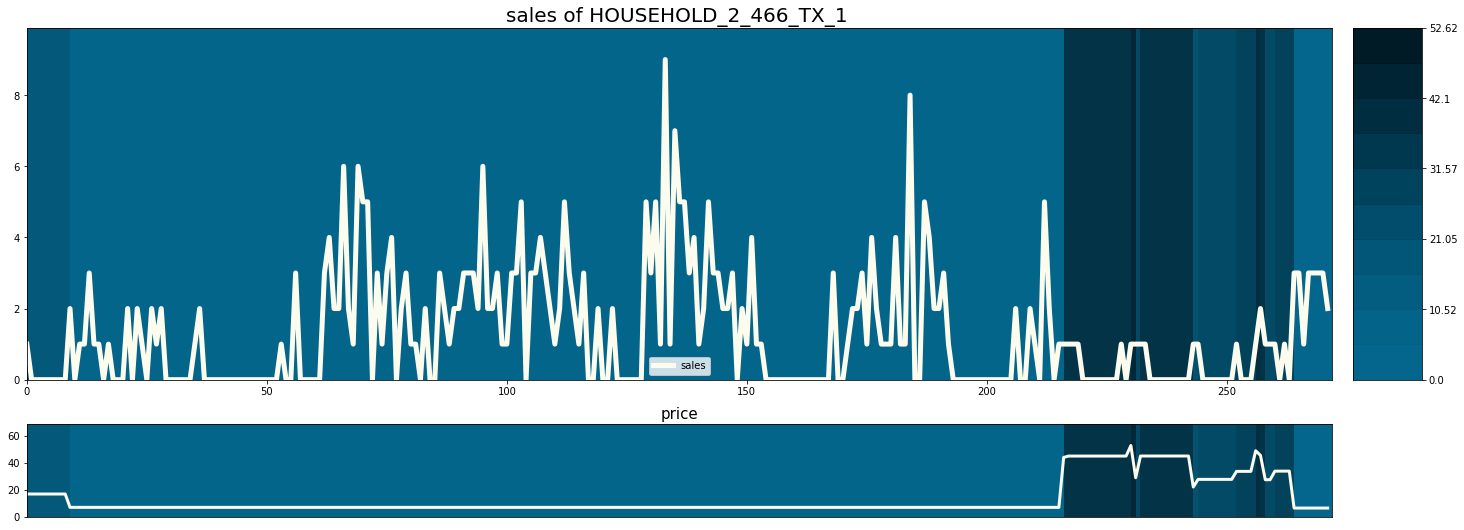

In [700]:
c='HOUSEHOLD_2_466_TX_1'
plot_sales_vs_discount(c)
plt.show()

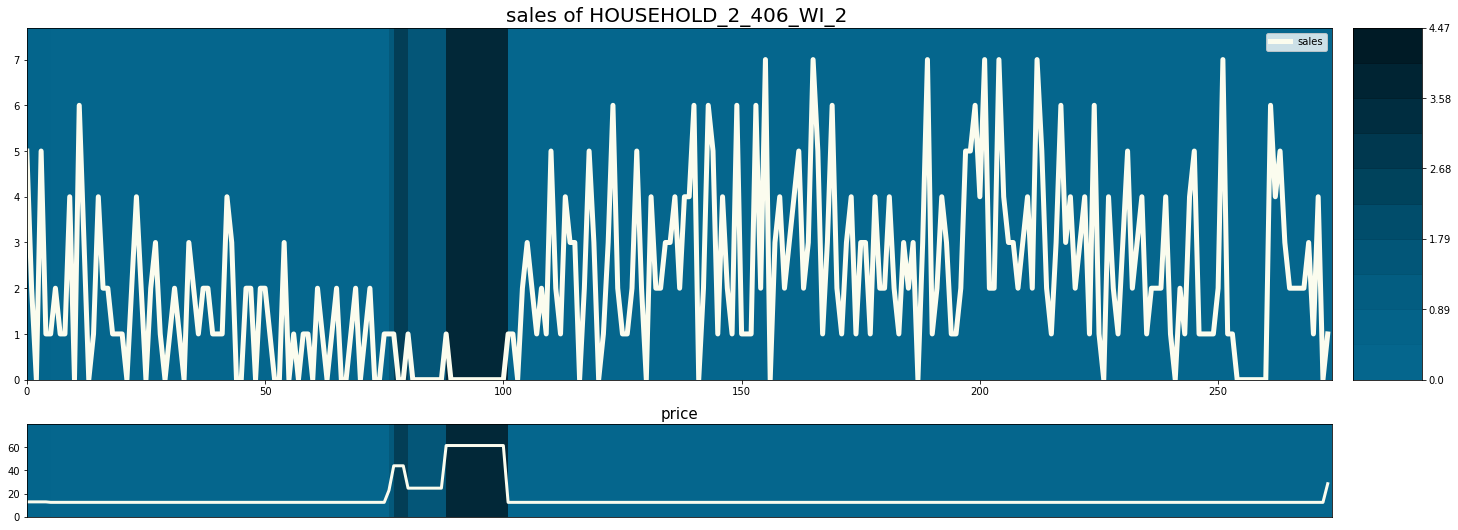

In [703]:
plot_sales_vs_discount('HOUSEHOLD_2_406_WI_2')
plt.show()

100%|██████████| 20/20 [00:14<00:00,  1.42it/s]HOUSEHOLD_1_033_TX_2



<Figure size 1800x10080 with 0 Axes>

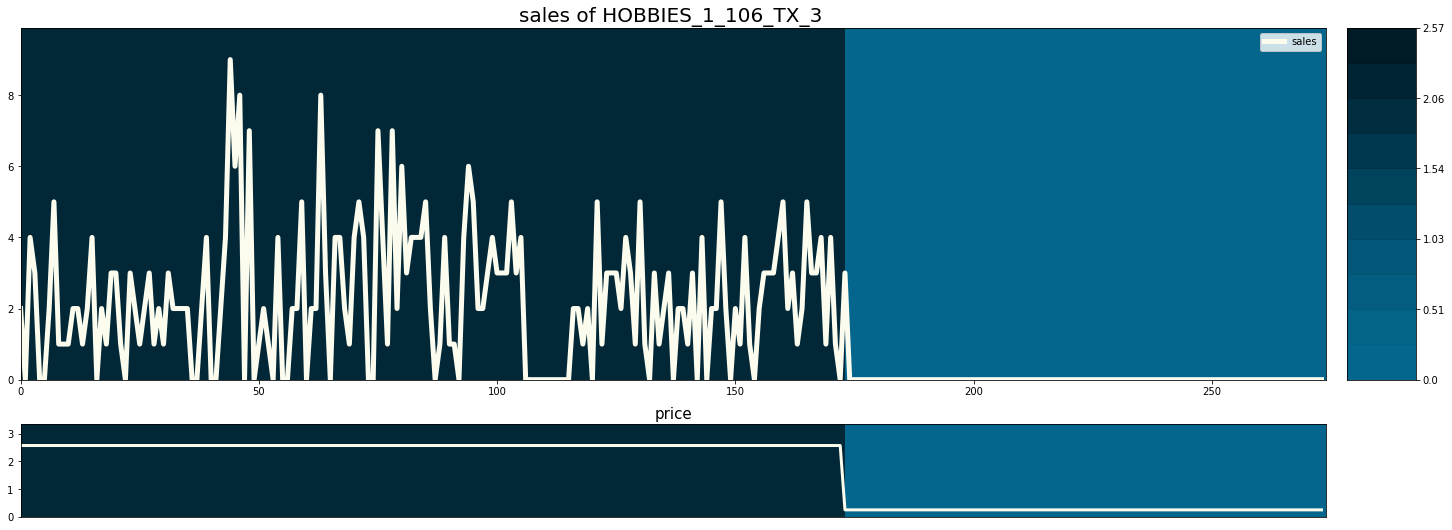

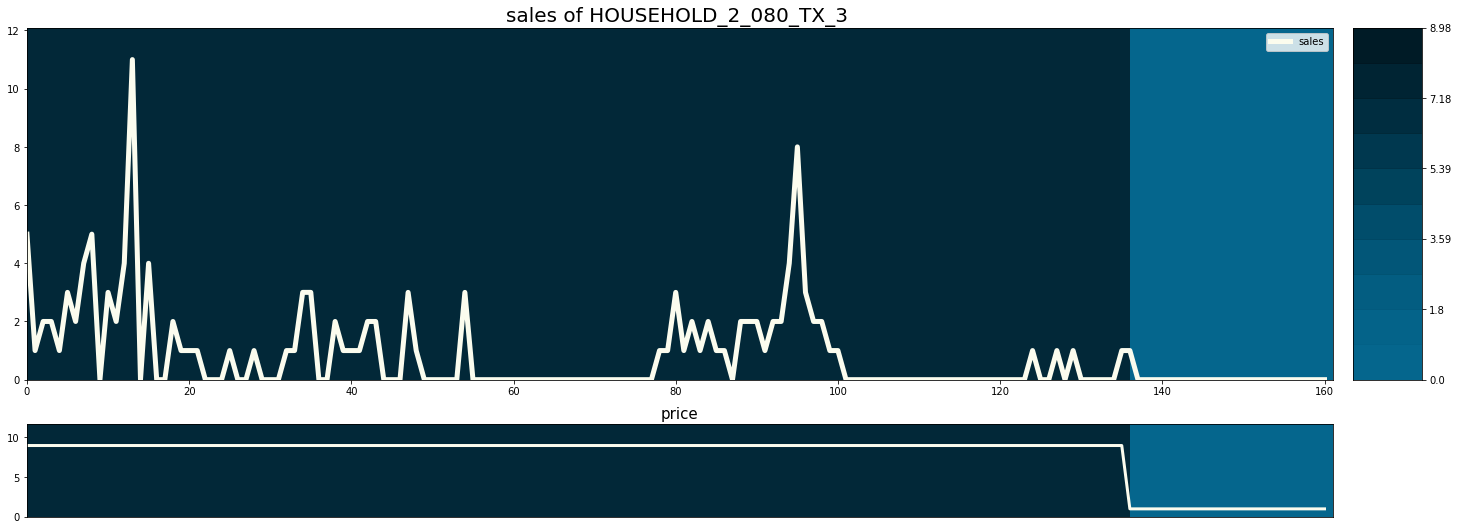

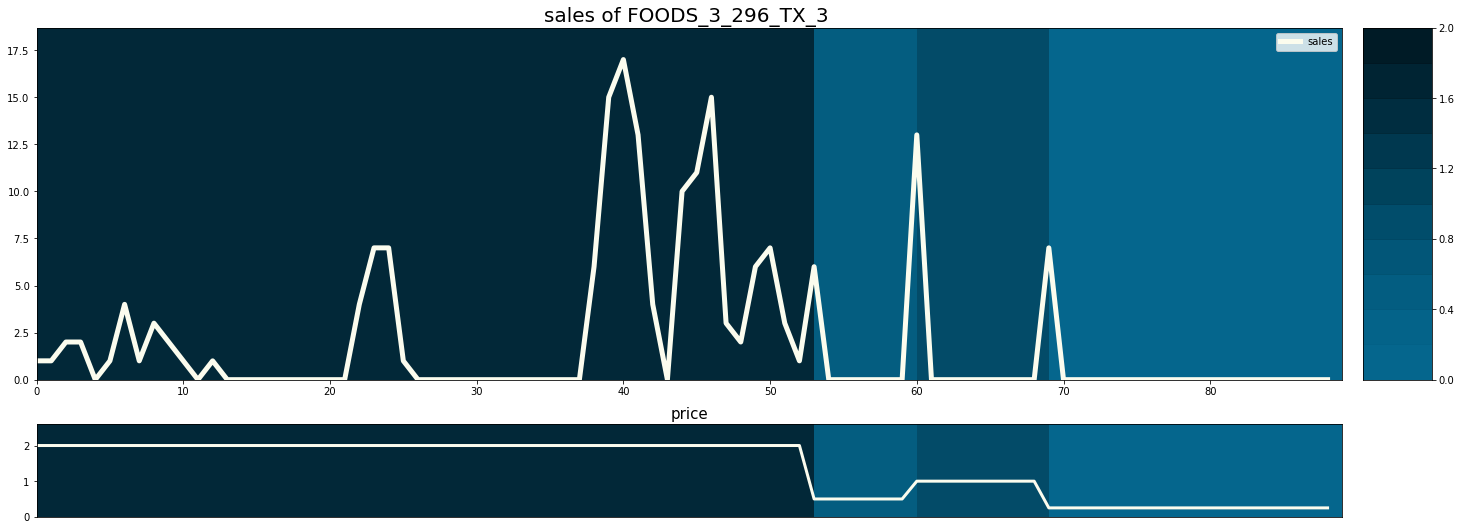

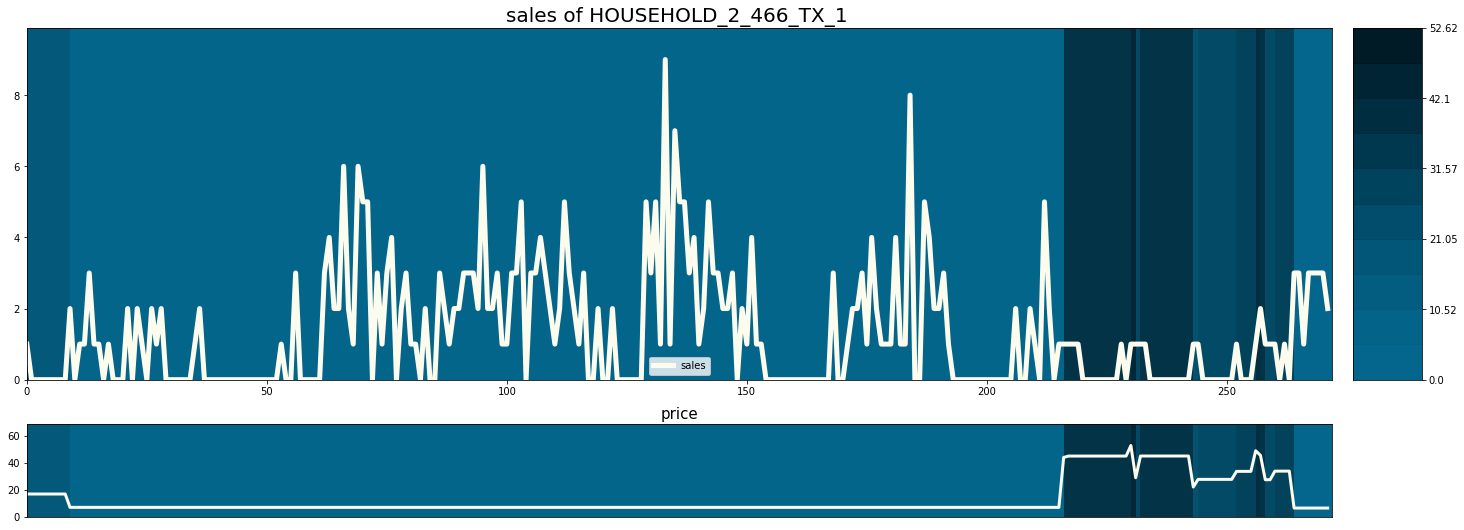

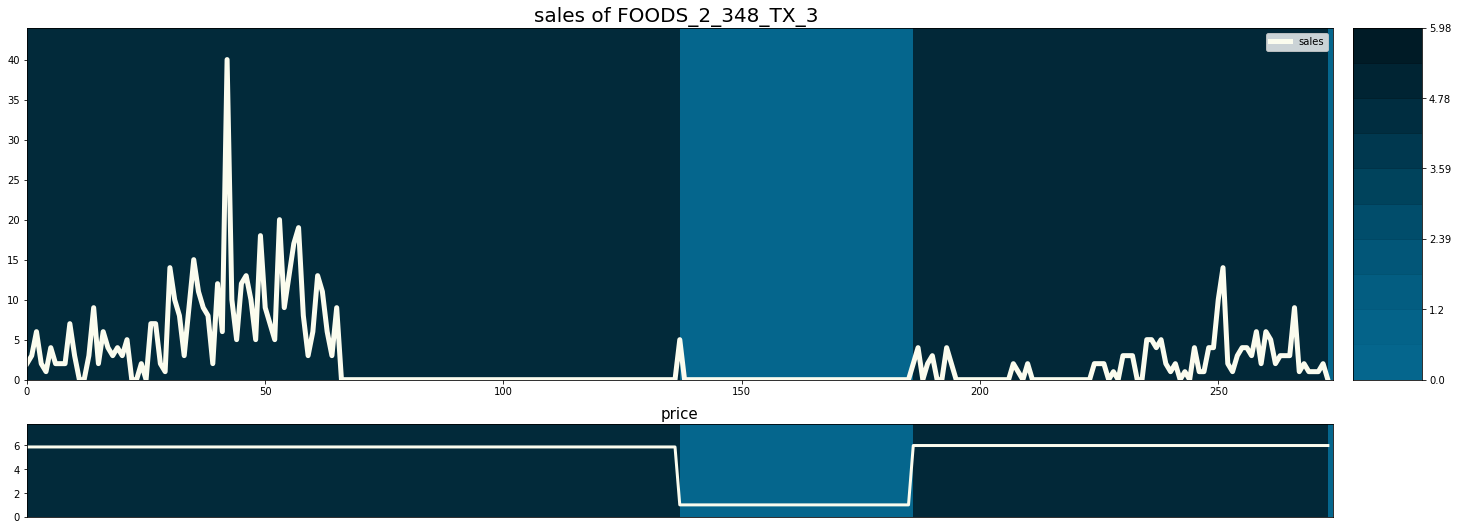

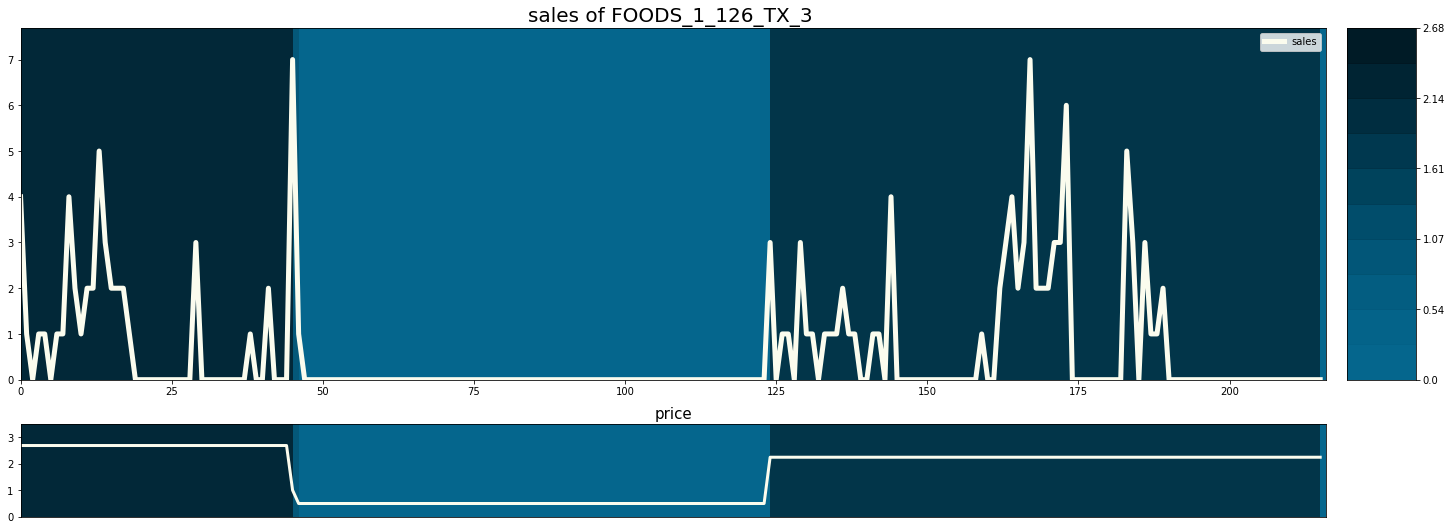

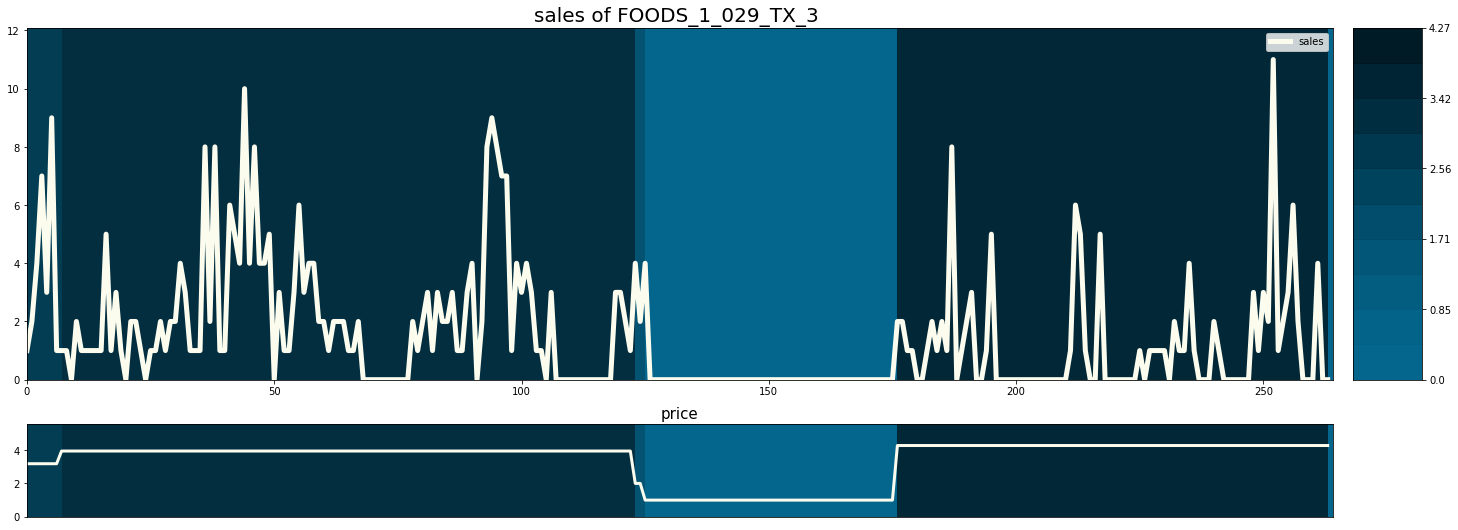

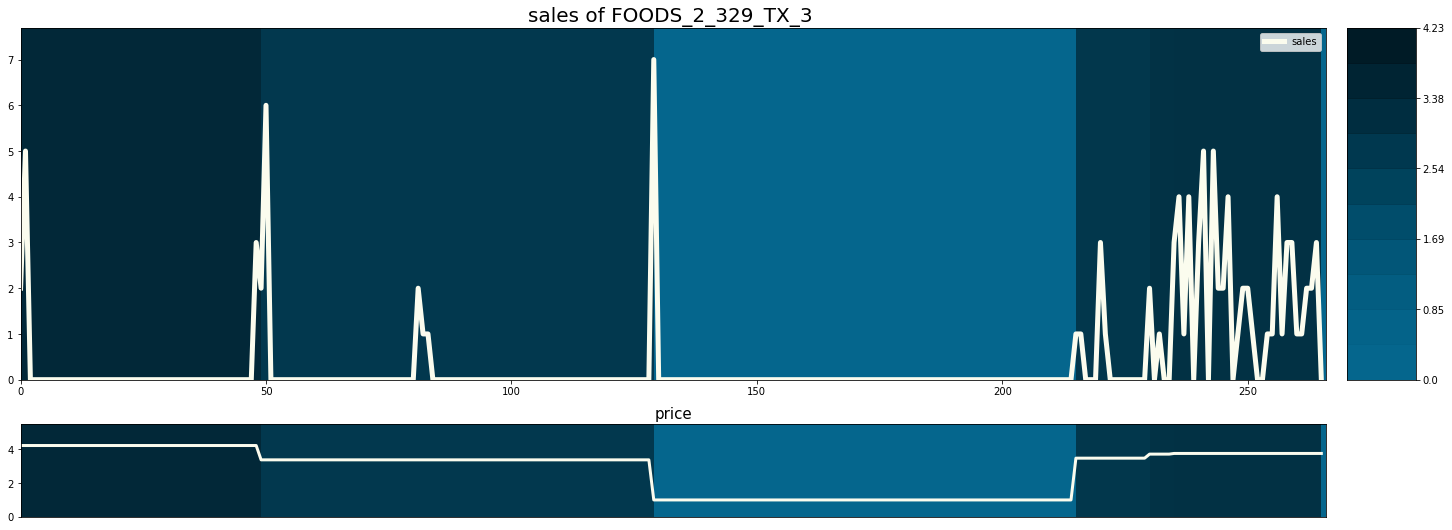

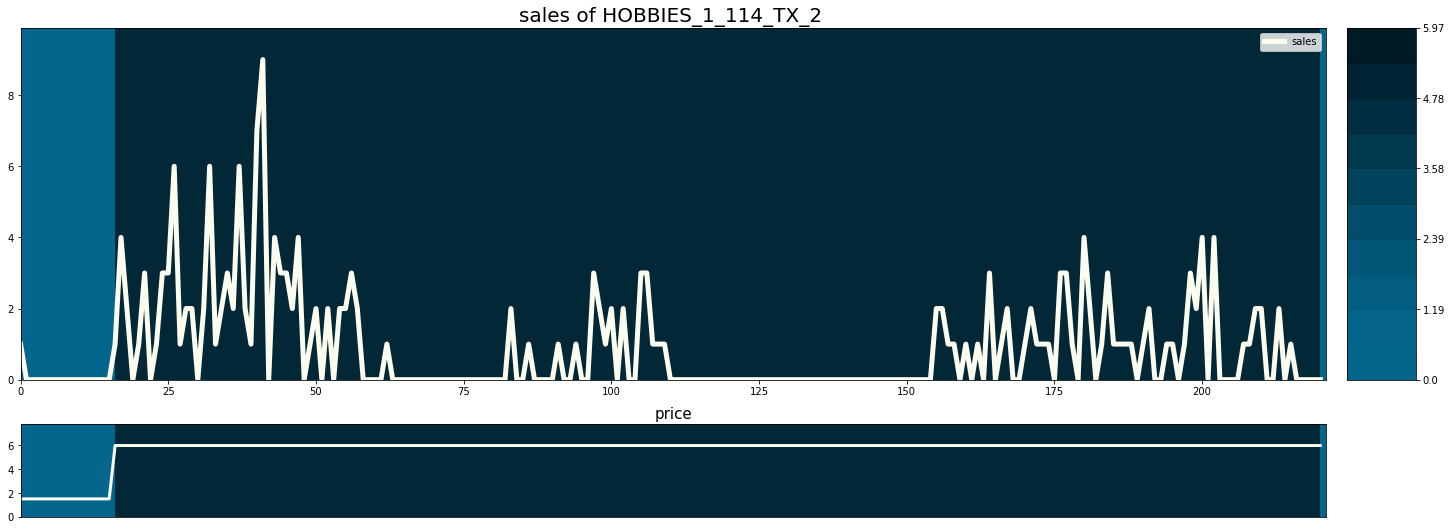

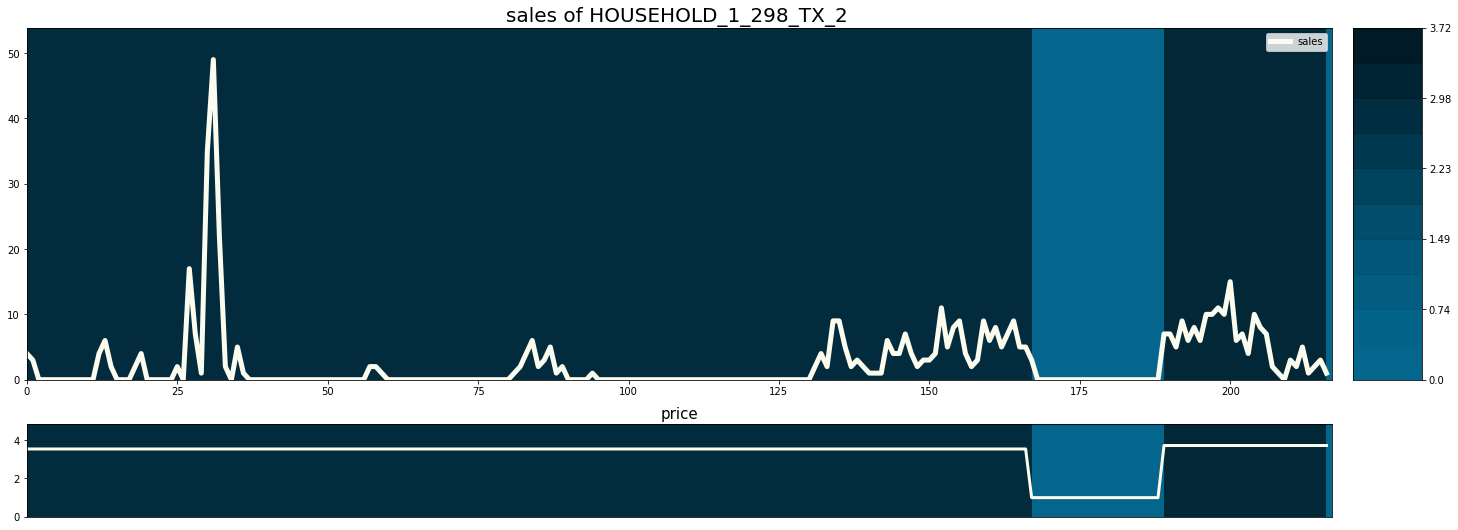

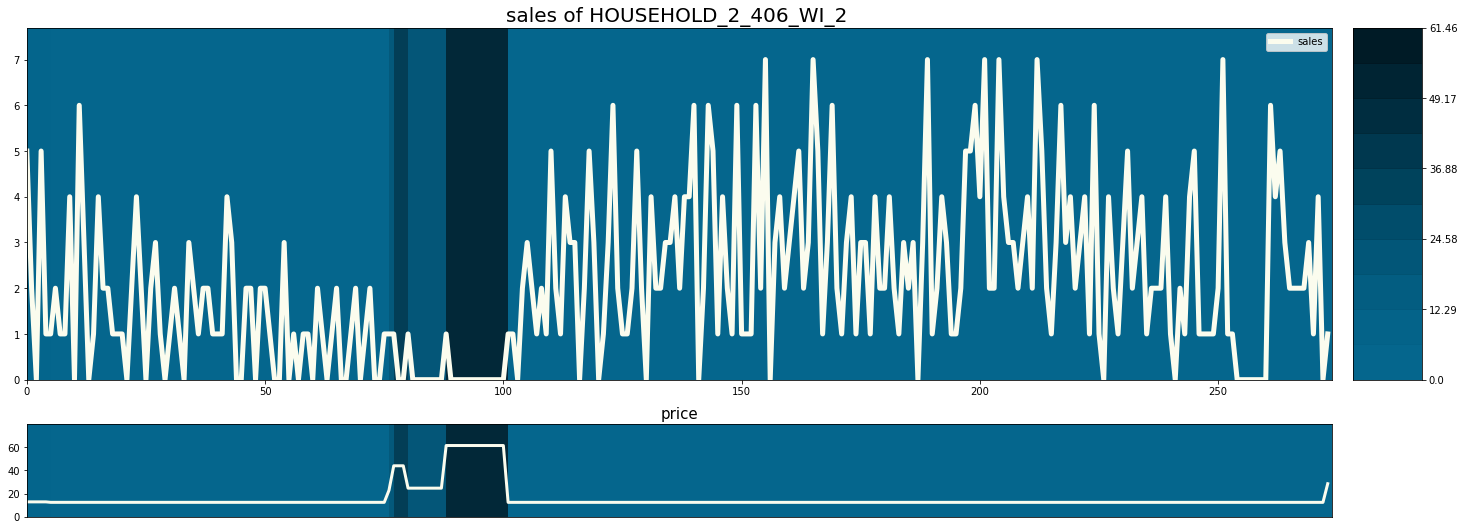

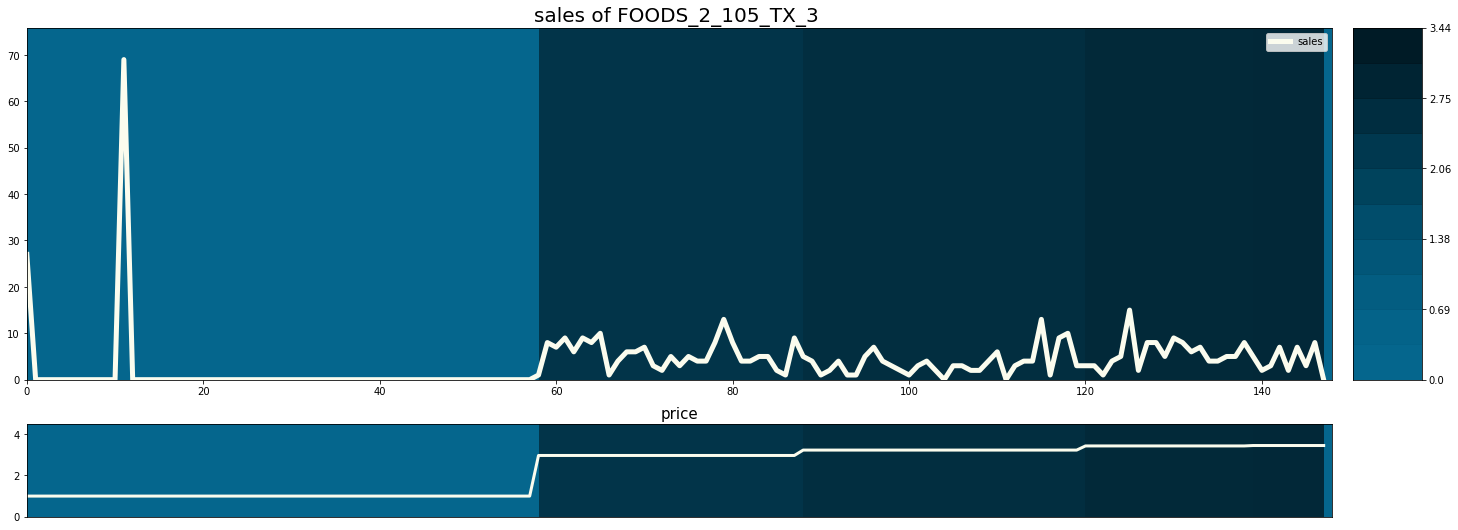

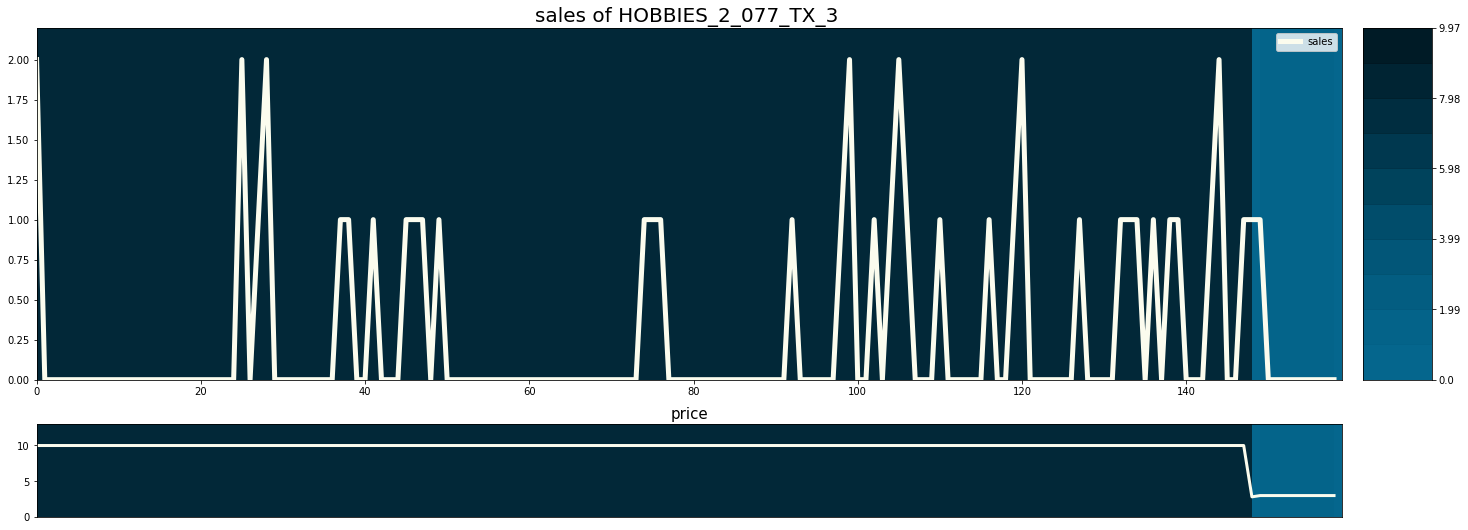

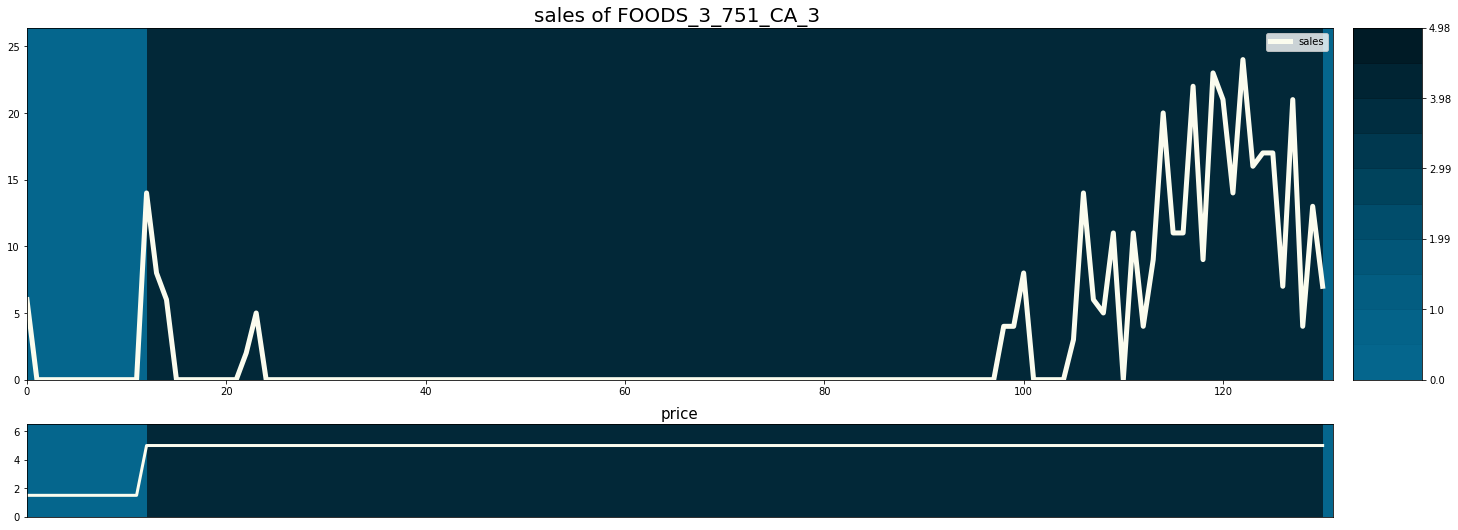

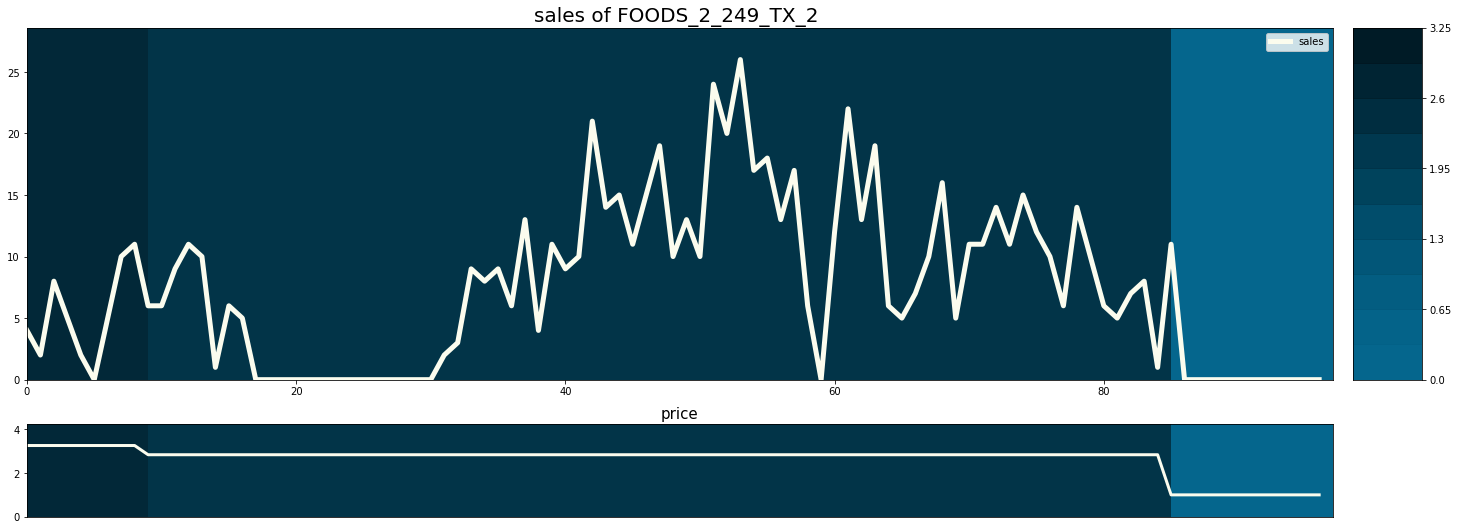

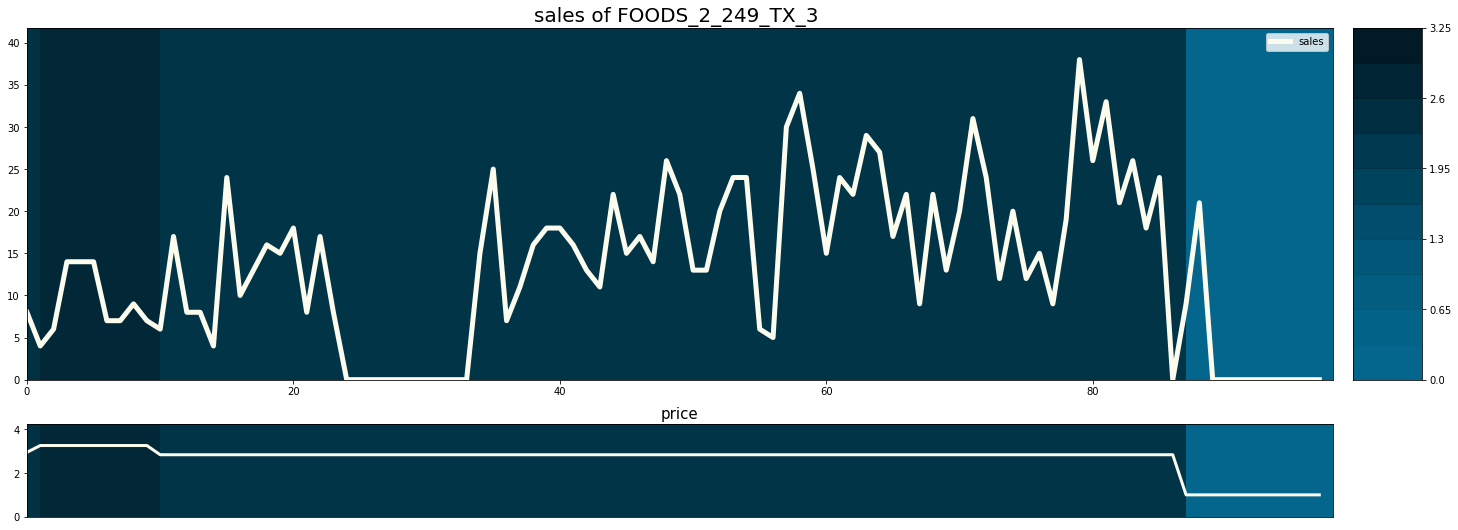

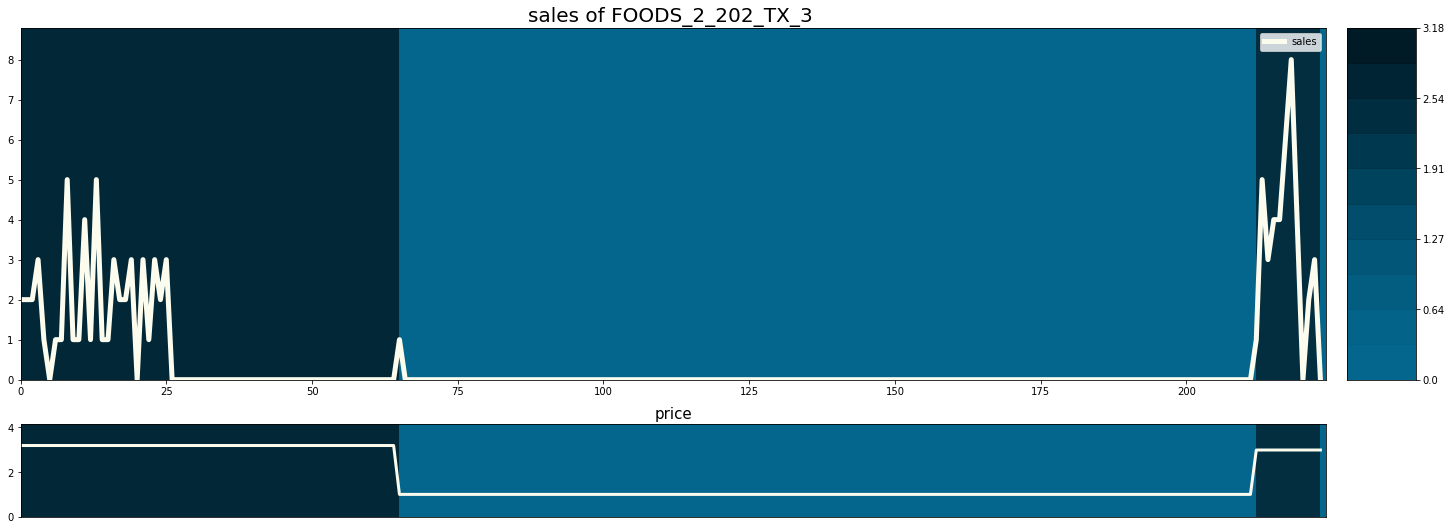

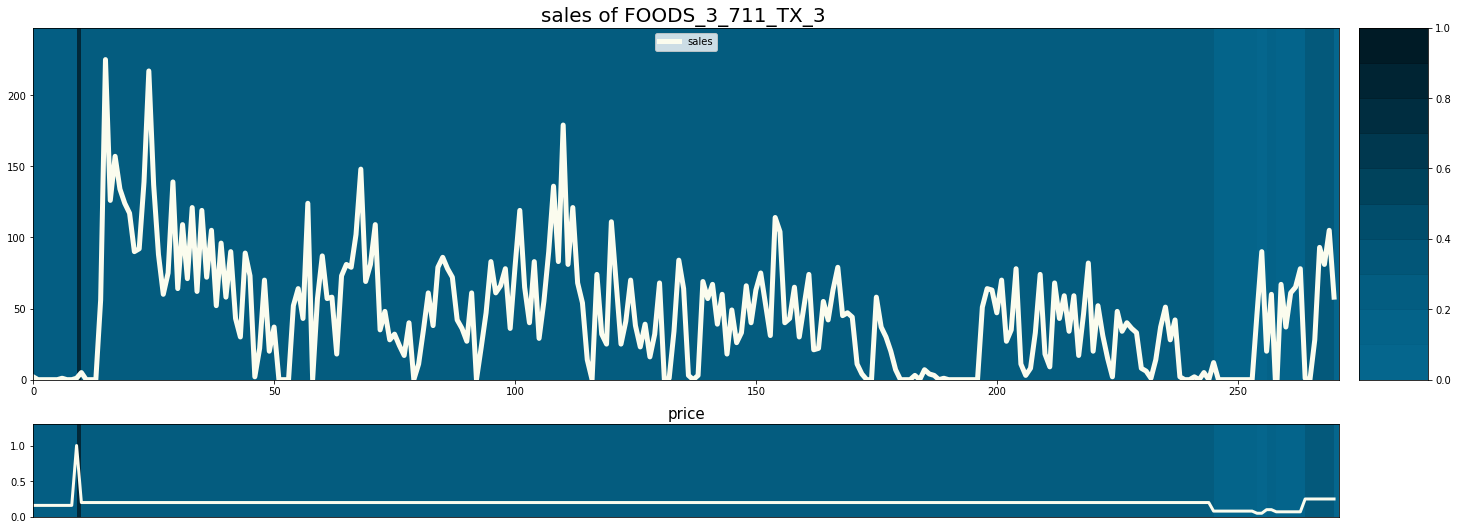

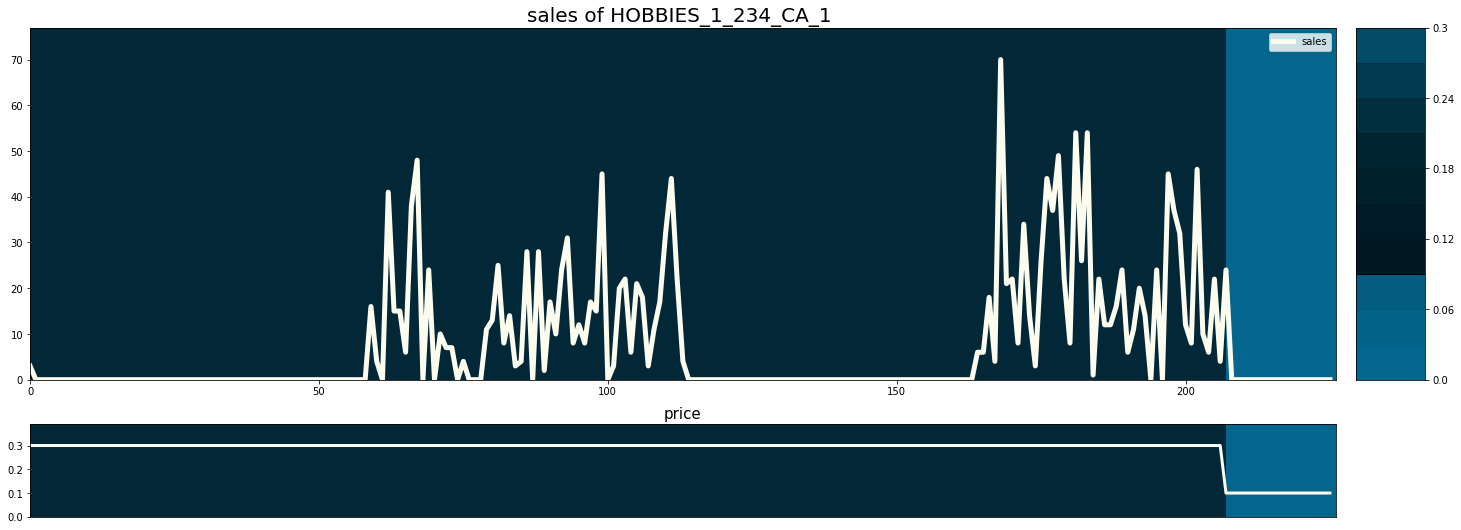

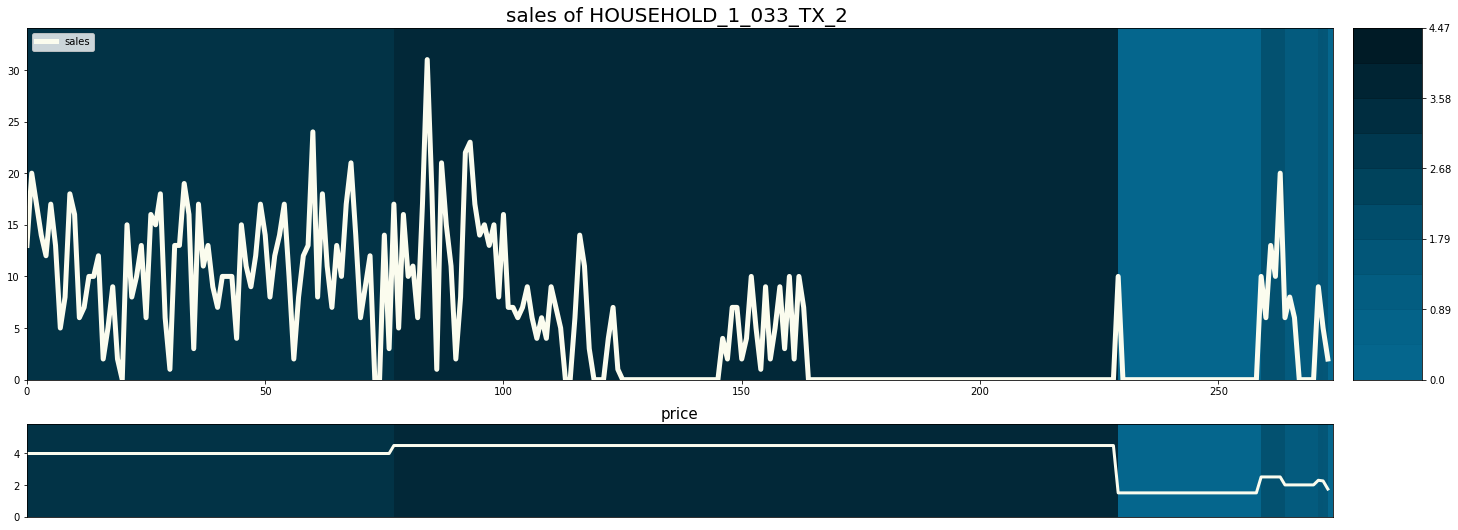

In [702]:

plots = len(top_discounted_items)
plt.figure(figsize=[25,7*plots])

for c in tqdm(top_discounted_items):
    plot_sales_vs_discount(c)
plt.show()